In [1]:
import pandas as pd
from Bio import SeqIO
import jsonlines
import re
tlp = 'C:\\Users\\jinya\\Desktop\\bio\\pa\\{}'
mseq = {}

# 读取Excel文件
file_path = 'C:\\Users\\jinya\\Desktop\\bio\\pa\\human_reference.xlsx'  # 替换为你的Excel文件路径
hdf = pd.read_excel(file_path)
hdf["ishuman"]=True
file_path = 'C:\\Users\\jinya\\Desktop\\bio\\pa\\animal_reference.xlsx'  # 替换为你的Excel文件路径
adf = pd.read_excel(file_path)
adf["ishuman"]=False
# 显示数据框的前五行
df = pd.concat([hdf,adf])

for name in ("apv.fasta", "hpv.fasta"):
    for v in SeqIO.parse(tlp.format(name), "fasta"):
        sid = v.id.split(".")[0]
        mseq[sid]=str(v.seq)
# mseq["M15953"]
df["seq"] = df["Genbank ID"].map(mseq)
dmap = {}

def get_lcr(info):
    etail, lhead, ltail = 0, 10000, 0
    for v in info["cds"]:
        gene =  v["qualifiers"]["product"] if "product" in v["qualifiers"] else ""
        gene =  v["qualifiers"]["gene"] if "gene" in v["qualifiers"] else gene
        if gene:
            if gene[0][0]=="E" or "early" in gene[0]:
                etail = max(etail, v["end"])
            elif gene[0][0]=="L" or "L1" in gene[0].upper() or "L2" in gene[0].upper() or "late" in gene[0] or "capsid" in gene[0]:
                ltail = max(ltail, v["end"])
                lhead = min(lhead,v["start"])
    return etail, lhead, ltail

for name in ("apv.json", "hpv.json"):
    with jsonlines.open(tlp.format(name)) as fp:
        for info in fp:
            sid = info["id"].split(".")[0]
            dmap[sid] = get_lcr(info)
df.head()

,Virus,Species Name,PaVE ID,Reference,Genbank ID,NCBI Refseq,Notes,ishuman,PaVE Name,Host Common Name,Host Scientific Name,Used Abbreviation,seq
0,HPV1,Mupapillomavirus 1,HPV1REF,"Clad et al., 1982",V01116,NaN,Revised,True,NaN,NaN,NaN,NaN,GTTAACTACCATCATTCATTATTCTAGTTACAACAAGAACCTAGGA...
1,HPV2,Alphapapillomavirus 4,HPV2REF,"Hirsch-Behnam et al., 1990",X55964,NC_001352,NaN,True,NaN,NaN,NaN,NaN,ATAATGTATAACTATAATCCTTTATTTAAAAATAGGGTGTGACCGA...
2,HPV3,Alphapapillomavirus 2,HPV3REF,"Delius and Hofmann, 1994",X74462,NaN,NaN,True,NaN,NaN,NaN,NaN,TCTAACTATAATTATAAATAACAATGCACATAATAAAAAGTAGGGA...
3,HPV4,Gammapapillomavirus 1,HPV4REF,"Egawa et al., 1993",X70827,NC_001457,NaN,True,NaN,NaN,NaN,NaN,GTCTGTAATGATAGTTGGCAACAATCATTACTTATAGCTATATATA...
4,HPV5,Betapapillomavirus 1,HPV5REF,"Zachow et al., 1987",M17463,NaN,Revised,True,NaN,NaN,NaN,NaN,AACGGTAAGTTGCAATTTCCTTGTACCAGGTGCGGTATTGGGATTT...


In [26]:
import re
import math
from Bio import motifs,SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
import traceback
pinstances,ninstances = [],[]
pva=pd.read_csv("pv_annotion.csv")


def polya_annotation(name):
    genome = df[df["Virus"]==name].iloc[0]
    genome_sequence, gid = genome.seq, genome["Genbank ID"]
    idxs = dmap[gid]
    records = []
    try:
        annotion=pva[pva["name"]==name].iloc[0]
    #     print(annotion)
        if idxs:
            early = (idxs[0]+1, idxs[1])  
            late  = (idxs[2]+1,len(genome.seq))

            ps, pe = max(early[0]-20, 0), max(early[1],early[0]+200)
            if not pd.isnull(annotion.e2_end):
                ps, pe =int(annotion.e2_end),max(int(annotion.l2_start),int(annotion.e2_end)+200)
            print(f"Name:{name} gid:{gid} Getting early polya site from genome in ", (ps,pe))
            if annotion.polyae:
                seq = genome_sequence[ps:pe]
                record = SeqRecord(Seq(seq),id=f"{name}E",name="early",description=str(int(annotion.polyae-ps)))
                records.append(record)
            ps, pe =  int(annotion.l1_end) if not pd.isnull(annotion.e2_end) else late[0], late[1]
            print(f".................Getting late polya site  from genome in", (ps,pe))
            seq = genome_sequence[ps:pe] 
            
            if not pd.isna(annotion.polyal1):
                record = SeqRecord(Seq(seq),id=f"{name}L",name="late",description=str(int(annotion.polyal1-ps)))
                
            else:
                record = SeqRecord(Seq(seq),id=f"{name}L",name="late",description="")
            records.append(record)
                
    except:
        traceback.print_exc()
        early = (idxs[0]+1, idxs[1])  
        late  = (idxs[2]+1,len(genome.seq))
        ps, pe = max(early[0]-20, 0), max(early[1],early[0]+200)
        print(f"Name:{name} gid:{gid} Getting early polya site from genome in ", (ps,pe))
        seq = genome_sequence[ps:pe] 
        record = SeqRecord(Seq(seq),id=f"{name}E",name="early",description="")
        records.append(record)
        ps, pe = late[0], late[1]
        print(f".................Getting late polya site  from genome in", (ps,pe))
        seq = genome_sequence[ps:pe] 
        record = SeqRecord(Seq(seq),id=f"{name}L",name="late",description="")
        records.append(record)
    return records

lst = ["BPV1","HPV1","HPV5","HPV11","HPV16","HPV18","HPV31","HPV47","HPV58","MmuPV1","HPV58"]
ret = []
for n in lst:
    rlst = polya_annotation(n)
    ret.extend(rlst)
# polya_annotation("HPV1") # Mmupv1 SfPV1
SeqIO.write(ret,"polya_region.fasta","fasta")
ret = []
for name in lst:
    genome = df[df["Virus"]==name].iloc[0]
    genome_sequence, gid = genome.seq, genome["Genbank ID"]
    record = SeqRecord(Seq(genome_sequence),id=f"{name}",description="")
#     record.format("fastasl")
    ret.append(record)
SeqIO.write(ret,"polya_region.fasta","fasta-2line")




Name:BPV1 gid:X02346 Getting early polya site from genome in  (3993, 4213)
.................Getting late polya site  from genome in (7096, 7945)
Name:HPV1 gid:V01116 Getting early polya site from genome in  (3797, 3997)
.................Getting late polya site  from genome in (6940, 7815)
Name:HPV5 gid:M17463 Getting early polya site from genome in  (4248, 4468)
.................Getting late polya site  from genome in (7468, 7746)
Name:HPV11 gid:M14119 Getting early polya site from genome in  (4351, 4571)
.................Getting late polya site  from genome in (7277, 7931)
Name:HPV16 gid:K02718 Getting early polya site from genome in  (4080, 4300)
.................Getting late polya site  from genome in (7155, 7904)
Name:HPV18 gid:X05015 Getting early polya site from genome in  (4138, 4358)
.................Getting late polya site  from genome in (7137, 7857)
Name:HPV31 gid:J04353 Getting early polya site from genome in  (4051, 4271)
.................Getting late polya site  from geno

11

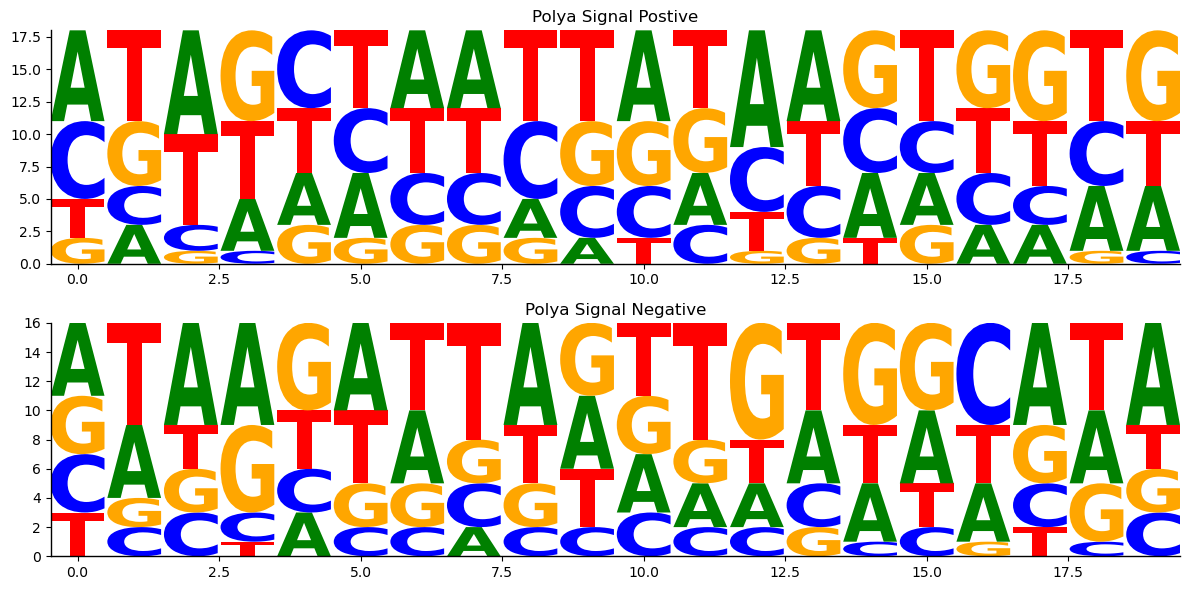

In [12]:
import logomaker
import matplotlib.pyplot as plt
import pandas as pd


# 计算每个位置的碱基频率
counts_df1 = pd.DataFrame(logomaker.alignment_to_matrix(pinstances))
counts_df2 = pd.DataFrame(logomaker.alignment_to_matrix(ninstances))

# 创建一个包含两个子图的图形，1行2列
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12, 6))

# 使用 logomaker 在第一个子图中绘制第一个 motif
logo1 = logomaker.Logo(counts_df1, ax=ax1)
ax1.set_title('Polya Signal Postive')
logo1.style_spines(visible=False)
logo1.style_spines(spines=['left', 'bottom'], visible=True)

# 使用 logomaker 在第二个子图中绘制第二个 motif
logo2 = logomaker.Logo(counts_df2, ax=ax2)
ax2.set_title('Polya Signal Negative')
logo2.style_spines(visible=False)
logo2.style_spines(spines=['left', 'bottom'], visible=True)

# 调整布局
plt.tight_layout()

# 显示图形
plt.show()

In [6]:
import re
import math
from Bio import motifs
from Bio.Seq import Seq
import pandas as pd


pva=pd.read_csv("pv_annotion.csv")
def get_polya(genome_sequence,start=0, end=None,label1=None,label2=None):
    # 定义常见的PolyA信号序列
    polya_patterns = ["AATAAA", "ATTAAA", "TATAAA", "AGTAAA", "AACAAG"]
    regex = re.compile("|".join(polya_patterns))
    sub_seq = genome_sequence[start:end] if end else genome_sequence[start:] 
    for m in regex.finditer(str(sub_seq)):
        idx = m.start()
        seq = genome_sequence[idx-10:idx]+genome_sequence[idx+6:idx+16]
#         print(abs(label-m.start()-start))
        if (label1 and abs(label1-m.start()-start)<10) or (label2 and abs(label2-m.start()-start)<10):
            print(".................",m.start()+start+3, m,1)
            print(".................",seq)
            yield seq,1
        else:
            print(".................",seq)
            print(".................",m.start()+start+3, m,0)
            yield seq, 0

def show(name):
    genome = df[df["Virus"]==name].iloc[0]
#     print(genome)
    genome_sequence, gid = genome.seq, genome["Genbank ID"]
    idxs = dmap[gid]
    annotion=pva[pva["name"]==name].iloc[0]
#     print(annotion)
    values=[]
    if idxs:
        early = (idxs[0]+1, idxs[1])  
        late  = (idxs[2]+1,len(genome.seq))
        
        ps, pe = max(early[0]-20, 0), max(early[1],early[0]+200)
        if not pd.isnull(annotion.e2_end):
            ps, pe =int(annotion.e2_end),max(int(annotion.l2_start),int(annotion.e2_end)+200)
        print(f"Name:{name} gid:{gid} Getting early polya site from genome in ", (ps,pe))
        if annotion.polyae:
            for i,(seq, label) in enumerate(get_polya(genome_sequence,ps,pe,annotion.polyae)):
                values.append((name,"early",i,seq,label))
                
        ps, pe =  int(annotion.l1_end) if not pd.isnull(annotion.e2_end) else late[0], late[1]
        print(f".................Getting late polya site  from genome in", (ps,pe))
        if annotion.polyal1:
            for i,(seq, label) in enumerate(get_polya(genome_sequence,ps,pe,annotion.polyal1,annotion.polyal2)):
                values.append((name,"late",i,seq,label))
        return pd.DataFrame(data=values,columns=["name","period","idx","seq","label"])
#     return genome_sequence

lst = ["BPV1","HPV1","HPV5","HPV11","HPV16","HPV18","HPV31","HPV47","SfPV1"]
dfs = [x for x in [show(v) for v in lst ] if x is not None]
train_df = pd.concat(dfs,axis=0)
train_df.to_csv(tlp.format("polya_train.csv"))
lst = ["MmuPV1","HPV58"]
dfs = [x for x in [show(v) for v in lst ] if x is not None]
test_df = pd.concat(dfs,axis=0)
test_df.to_csv(tlp.format("polya_test.csv"))

pinstances,ninstances = train_df[train_df["label"]==1]["seq"].values,train_df[train_df["label"]==0]["seq"].values


# show("HPV5") # Mmupv1 SfPV1
# from Bio.SeqRecord import SeqRecord
# pmotif,nmotifs = motifs.create(pinstances), motifs.create(ninstances)
# precords = [SeqRecord(Seq(seq), id="PV_POLYA"+str(i), description="") for i, seq in enumerate(pinstances)]
# nrecords = [SeqRecord(Seq(seq), id="PV_POLYA"+str(i), description="") for i, seq in enumerate(ninstances)]
# SeqIO.write(precords, "C:\\Users\\jinya\\Desktop\\bio\\pa\\pinstances.fasta", "fasta")
# SeqIO.write(nrecords, "C:\\Users\\jinya\\Desktop\\bio\\pa\\ninstances.fasta", "fasta")

# with open("pmotif.meme", "w") as handle:
#     handle.write(pmotif.format("pfm"))
# with open("nmotifs.meme", "w") as handle:
#     handle.write(nmotifs.format("pfm"))


Name:BPV1 gid:X02346 Getting early polya site from genome in  (3993, 4213)
................. 4181 <re.Match object; span=(185, 191), match='AATAAA'> 1
................. CTTTTAGGTGCAAAGACTTT
................. TTCATGTTGTGGAAGGCTGT
................. 4205 <re.Match object; span=(209, 215), match='AGTAAA'> 0
.................Getting late polya site  from genome in (7096, 7945)
................. TTAACAATAACATCACCGTT
................. 7110 <re.Match object; span=(11, 17), match='TATAAA'> 0
................. 7157 <re.Match object; span=(58, 64), match='AATAAA'> 1
................. CCAGCTAACTAGCTGCTGAC
................. CTCAGATTTATTGTGTCCAC
................. 7910 <re.Match object; span=(811, 817), match='AGTAAA'> 0
Name:HPV1 gid:V01116 Getting early polya site from genome in  (3797, 3997)
................. 3986 <re.Match object; span=(186, 192), match='AATAAA'> 1
................. CTTGTAATTTTTATTTTTTG
.................Getting late polya site  from genome in (6940, 7815)
................. 7382 <

In [5]:



def get_polya(genome_sequence,start=0, end=None,label1=None,label2=None):
    # 定义常见的PolyA信号序列
    polya_patterns = ["AATAAA", "ATTAAA", "TATAAA", "AGTAAA", "AACAAG"]
    # print(etail, lhead, ltail)
    regex = re.compile("|".join(polya_patterns))
    sub_seq = genome_sequence[start:end] if end else genome_sequence[start:] 
    for m in regex.finditer(str(sub_seq)):
        idx = m.start()
        seq = genome_sequence[idx-10:idx]+genome_sequence[idx+6:idx+16]
#         print(abs(label-m.start()-start))
        if (label1 and abs(label1-m.start()-start)<10) or (label2 and abs(label2-m.start()-start)<10) :
            print(".................",m.start()+start+3, m,1)
            print(".................",seq)
        else:
            print(".................",seq)
            print(".................",m.start()+start+3, m,0)

def predict(name):
    genome = df[df["Virus"]==name].iloc[0]
    genome_sequence, gid = genome.seq, genome["Genbank ID"]
    idxs = dmap[gid]
    try:
        annotion=pva[pva["name"]==name].iloc[0]
    #     print(annotion)
        if idxs:
            early = (idxs[0]+1, idxs[1])  
            late  = (idxs[2]+1,len(genome.seq))

            ps, pe = max(early[0]-20, 0), max(early[1],early[0]+200)
            if not pd.isnull(annotion.e2_end):
                ps, pe =int(annotion.e2_end),max(int(annotion.l2_start),int(annotion.e2_end)+200)
            print(f"Name:{name} gid:{gid} Getting early polya site from genome in ", (ps,pe))
            if annotion.polyae:
                get_polya(genome_sequence,ps,pe,annotion.polyae)
            ps, pe =  int(annotion.l1_end) if not pd.isnull(annotion.e2_end) else late[0], late[1]
            print(f".................Getting late polya site  from genome in", (ps,pe))
            if annotion.polyal1:
                get_polya(genome_sequence, ps,pe,annotion.polyal1,annotion.polyal2)
    except:
        early = (idxs[0]+1, idxs[1])  
        late  = (idxs[2]+1,len(genome.seq))
        ps, pe = max(early[0]-20, 0), max(early[1],early[0]+200)
        get_polya(genome_sequence,ps,pe)
        ps, pe = late[0], late[1]
        get_polya(genome_sequence, ps,pe)

predict("HPV6") # Mmupv1 SfPV1

4358 4578
................. AATCTTGGTTATAGGAGGGA
................. 4380 <re.Match object; span=(19, 25), match='AGTAAA'> 0
................. ATTAATTGTGGCAAGAATGC
................. 4556 <re.Match object; span=(195, 201), match='ATTAAA'> 0
................. GAAAGTGCAACCACGTCTGC
................. 7409 <re.Match object; span=(114, 120), match='AATAAA'> 0
